# Milestone Project 1: Food Vision Big

## Check GPU

Check if the GPU is compatible with mix precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowning this, in order to use mixed precision training we need a GPU score of a 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Quadro P2000 (UUID: GPU-45eb6a28-8b9a-6cc9-5299-32453fd1cd04)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks.

Rather than rewrite all of these, we can import a script and load them into our notebook

In [2]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the [guide](https://www.tensorflow.org/datasets/overview)

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# List all avaiable datasets
datasets_list = tfds.list_builders() # get all available datasests in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS?

True


In [5]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in a tuple format (data,label)
                                             with_info=True)                                             

## Exploring the Food101 data from TensorFlow DataSets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot-encoded?)
* Do the labels match up with the class names?


In [6]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor,label)

In [9]:
# What does one sample look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f""""
    Image Shape: {image.shape}
    Image Datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)

"
    Image Shape: (512, 512, 3)
    Image Datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 41
    Class name (str form): french_onion_soup
    


In [35]:
# What does our image tensor from TFDS's Food 101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

In [11]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

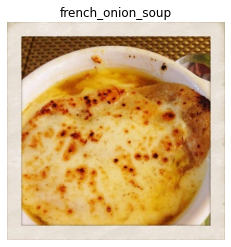

In [12]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform beset when data is in a certain way (e.g. batched, normalized, etc).

However, not all data comes likes this.

So, in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 - 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TF likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

Since we are going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype from `uint8` to `float32`

In [13]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    # image = image/255. (for models that need normalization)
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [14]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

We are now going to make our data input pipeline run fast.

For more resources, reference the following [guide](https://www.tensorflow.org/guide/data_performance)

In [15]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing
test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch." 

## Create modelling callbacks

We are going to create callbacks to help us while our model trains:
* TensorBoard callback to log training results
* ModelCheckpoint callback to save our model's progress after feature extraction

In [29]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # note ... you need to spell out accuracy here (val_acc) will not work
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # dont print whether or not model is being saved

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [47]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed float 16

In [49]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create functional model
inputs = layers.Input(shape=input_shape,name="input_layer")
# Note: EfficientNextBX has re-scaling built in but if you dont ...
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float_32")(x)
model=tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [19]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float_32 (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies

In [21]:
# Check the dtype_policy attributes of layers
for layer in model.layers:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float_32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variables in
* `layer.dtype_policy`: the datatype policy layer is based on how the variables are computed

**Note**: Due to our GPU not being up to snuff, we are unable to compute layers in `float16`. Mixed precision cannot be performed

In [24]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine tune some of the frozen layers

In [30]:
# Fit feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_classes_all_data_feature_extract/20221227-112846
Epoch 1/3
2368/2368 [==============================] - 318s 134ms/step - loss: 0.8771 - accuracy: 0.7695 - val_loss: 0.9529 - val_accuracy: 0.7405
Epoch 2/3
2368/2368 [==============================] - 314s 132ms/step - loss: 0.8220 - accuracy: 0.7815 - val_loss: 0.9754 - val_accuracy: 0.7325
Epoch 3/3
2368/2368 [==============================] - 311s 131ms/step - loss: 0.7780 - accuracy: 0.7947 - val_loss: 0.9687 - val_accuracy: 0.7328


In [31]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 93s 118ms/step - loss: 0.9844 - accuracy: 0.7315


[0.9844332933425903, 0.73148512840271]

## Off to you

Create FoodVision Big:
1. Save the model
2. Load saved model
3. Check the layers in the base model and see what dtype policy
4. Check loaded model performance

In [32]:
# 1. Save a model
model.save("saved_efficientnetb0_classes_all_data_feature_extract")

INFO:tensorflow:Assets written to: saved_efficientnetb0_classes_all_data_feature_extract\assets


INFO:tensorflow:Assets written to: saved_efficientnetb0_classes_all_data_feature_extract\assets


In [33]:
# 2. Load saved model
loaded_saved_model = tf.keras.models.load_model("saved_efficientnetb0_classes_all_data_feature_extract")

In [35]:
# 3. Check the layers in the base model and see what dtype policy
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [36]:
# 4. Check loaded model performance
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 98s 123ms/step - loss: 0.9844 - accuracy: 0.7315


## Further evaulating the loaded model

Next steps:
1. Get summary of loaded model
2. Set all of the layers to trainable (so they're unfrozen)
3. Check to see what dtype_policy of the layers in your loaded model

In [37]:
# 1. Get summary
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float_32 (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [40]:
# 2. Set layers to trainable
for layer in loaded_saved_model.layers:
    layer.trainable = True
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)


# 3. Check dtype of base model or EfficientNetB0
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float_32 True float32 <Policy "float32">
input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "float32">
normalization True float32 <Policy "float32">
tf.math.truediv True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">
block1a_se_squeeze True float32 <Policy "float32">
block1a_se_reshape True float32 <Policy "float32">
block1a_se_reduce True float32 <Policy "float32">
block1a_se_expand True float32 <Policy "float32">
block1a_se_excite True float32 <Policy "float32">
block1a_project_conv

In [45]:
# Setup early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save best model during training
checkpoint_path = "fine_tune_checkpoints/"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
                                             

In [48]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [46]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [49]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                     epochs=100, # fine-tune for a maximum of 100 epochs
                                                                     steps_per_epoch=len(train_data),
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                                     callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                     model_checkpoint, # save only the best model during training
                                                                     early_stopping,
                                                                     reduce_lr]) # stop model after X epochs of no improvements # 

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20221227-152617
Epoch 1/100
2368/2368 [==============================] - 1473s 621ms/step - loss: 0.2135 - accuracy: 0.9375 - val_loss: 0.9668 - val_accuracy: 0.7715 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 1461s 617ms/step - loss: 0.1194 - accuracy: 0.9634 - val_loss: 1.0360 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9739
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1448s 612ms/step - loss: 0.0841 - accuracy: 0.9739 - val_loss: 1.0895 - val_accuracy: 0.7791 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 1435s 606ms/step - loss: 0.0155 - accuracy: 0.9968 - val_loss: 1.1249 - val_accuracy: 0.8051 - lr: 2.0000e-05


In [51]:
# Save model
loaded_saved_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision\assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision\assets


In [52]:
# Loading saved model
loaded_fine_tuned_model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [53]:
# Evaluating saved model
results_loaded_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)

790/790 [==============================] - 97s 121ms/step - loss: 1.1366 - accuracy: 0.7961


In [ ]:
# Visualize on Tensorboard
!tensorboard dev upload --logdir ./training_logs/ --name "Feature Extract vs. Fine Tuned" --one_shot
!tensorboard dev list
!tensorboard dev delete --experiment_id YXn0vtMTR4qDGRJ5WBSvKg